In [1]:
%load_ext autoreload

In [131]:
%autoreload
#from model import SSVAE
import train_utils

In [3]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [4]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [5]:
device = torch.device("cuda")

# Generation of sine waves dataset

In [6]:
np.random.seed(1)

T = 40
L = 200
N = 2000

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
labels = np.random.randint(2, size=N) * 2 - 1
waves = np.sin((x.T / ((np.random.rand(N)**2)*T + 2)).T).astype('float64').reshape(N, L, 1)

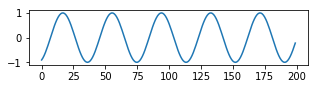

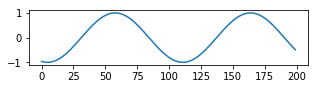

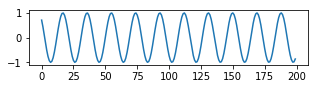

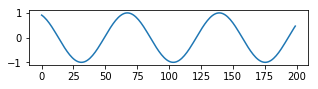

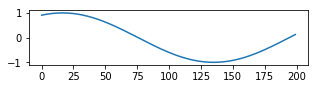

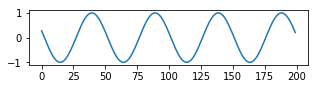

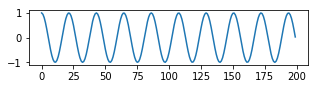

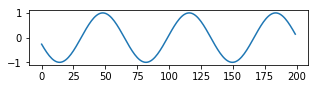

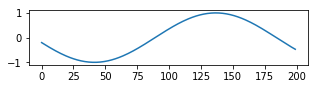

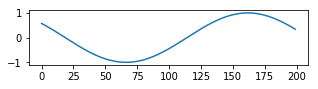

In [7]:
for i in range(10):
    plt.figure(figsize=(5, 1))
    plt.plot(waves[i])

In [8]:
target_features = ['w', 'rw']

In [9]:
lwaves = np.array([waves[i] if labels[i] == 1 else waves[i]*(-1) for i in range(N)])
rwaves = np.array(waves)

In [10]:
data = np.stack((rwaves, lwaves), axis=2).squeeze()
N = len(data)
N

2000

Text(0.5,1,'Y = +1')

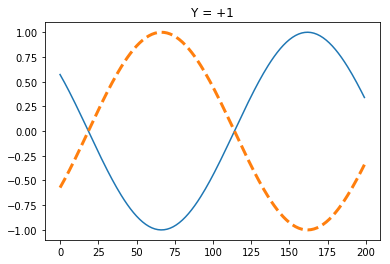

In [11]:
plt.plot(data[9, :, 0])
plt.plot(data[9, :, 1], linestyle='--', lw=3)
plt.title('Y = +1')

Text(0.5,1,'Y = -1')

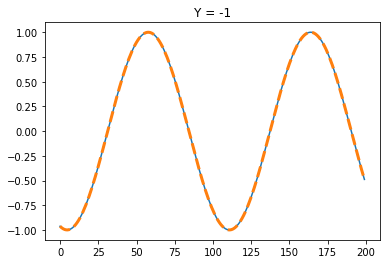

In [12]:
plt.plot(data[1, :, 0])
plt.plot(data[1, :, 1], linestyle='--', lw=3)
plt.title('Y = -1')

In [13]:
label_id = {}
for label in Counter(labels):
    if label != 'nan':
        label_id[label] = len(label_id)
num_labels = len(label_id)
label_id['nan'] = num_labels
num_labels

2

In [14]:
full_labels = np.array([label_id[label] for label in labels])
corrupted_labels = np.array(full_labels)
np.random.seed(0)
corrupted_labels[np.random.choice(len(corrupted_labels), int(0.5*len(corrupted_labels)), replace=False)] = num_labels

In [15]:
batch_size = 512

In [16]:
train_inds = np.arange(int(N*5/6))
test_inds = np.arange(int(N*5/6), N)

In [17]:
len(train_inds), len(test_inds)

(1666, 334)

In [18]:
data_tensor = torch.stack([torch.Tensor(x) for x in data])

In [19]:
corrupted_labels_tensor = torch.Tensor(corrupted_labels).long()
full_labels_tensor = torch.Tensor(full_labels).long()

In [20]:
ts_dataset_train = torch.utils.data.TensorDataset(data_tensor[train_inds], 
                                                  corrupted_labels_tensor[train_inds], 
                                                  full_labels_tensor[train_inds])
ts_dataset_test = torch.utils.data.TensorDataset(data_tensor[test_inds], 
                                                 corrupted_labels_tensor[test_inds], 
                                                 full_labels_tensor[test_inds])

In [21]:
train_loader = torch.utils.data.DataLoader(ts_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ts_dataset_test, batch_size=batch_size, shuffle=True)

# Fit models

In [107]:
epochs = 1000
LOGS = 5

In [108]:
def get_log(mod, latent_dim):
    log = []
    for _ in range(LOGS):
        m, trl, tel, mse, iwae = train_utils.fit_model_report(mod, False,  target_features, num_labels, 
                                                        latent_dim, L, device, epochs, 
                                                        train_loader, test_loader, 100)
        log.append((m, trl, tel, mse, iwae))
    return log

In [109]:
full_log = get_log('full', 2)

conv size: 335
fc3 4 20
epoch: 100
====> Test set loss: 7505.5479, MSE: 70.7954, CE: 0.0162, CE(full): 0.0162, KL: 832.5247
1.0
1.0
epoch: 200
====> Test set loss: 6493.8564, MSE: 59.8006, CE: 0.0146, CE(full): 0.0146, KL: 1010.0670
1.0
1.0
epoch: 300
====> Test set loss: 6066.3125, MSE: 54.9688, CE: 0.0177, CE(full): 0.0177, KL: 1117.6532
1.0
1.0
epoch: 400
====> Test set loss: 5817.6133, MSE: 51.8786, CE: 0.0200, CE(full): 0.0200, KL: 1235.4534
1.0
1.0
epoch: 500
====> Test set loss: 5519.7568, MSE: 48.4762, CE: 0.0239, CE(full): 0.0239, KL: 1315.6055
1.0
1.0
epoch: 600
====> Test set loss: 5449.5591, MSE: 47.6748, CE: 0.0258, CE(full): 0.0258, KL: 1333.1912
1.0
1.0
epoch: 700
====> Test set loss: 5236.7363, MSE: 45.3386, CE: 0.0246, CE(full): 0.0246, KL: 1376.2534
1.0
1.0
epoch: 800
====> Test set loss: 5349.6411, MSE: 46.4977, CE: 0.0226, CE(full): 0.0226, KL: 1372.5750
1.0
1.0
epoch: 900
====> Test set loss: 5093.7480, MSE: 44.0299, CE: 0.0257, CE(full): 0.0257, KL: 1350.6235
1.0


In [110]:
semi_log = get_log('semi', 2)

conv size: 335
fc3 4 20
epoch: 100
====> Test set loss: 8197.3457, MSE: 79.0829, CE: 0.0179, CE(full): 0.0169, KL: 556.6225
1.0
1.0
epoch: 200
====> Test set loss: 7321.6968, MSE: 69.3010, CE: 0.0132, CE(full): 0.0125, KL: 767.3919
1.0
1.0
epoch: 300
====> Test set loss: 6946.9160, MSE: 65.2310, CE: 0.0130, CE(full): 0.0126, KL: 832.0499
1.0
1.0
epoch: 400
====> Test set loss: 6641.2598, MSE: 61.8601, CE: 0.0142, CE(full): 0.0141, KL: 893.4965
1.0
1.0
epoch: 500
====> Test set loss: 6484.0938, MSE: 59.8192, CE: 0.0169, CE(full): 0.0176, KL: 984.0140
1.0
1.0
epoch: 600
====> Test set loss: 6408.1221, MSE: 58.6763, CE: 0.0221, CE(full): 0.0240, KL: 1054.4731
1.0
1.0
epoch: 700
====> Test set loss: 6178.4697, MSE: 56.2743, CE: 0.0227, CE(full): 0.0234, KL: 1074.8817
1.0
1.0
epoch: 800
====> Test set loss: 6162.0352, MSE: 56.0760, CE: 0.0254, CE(full): 0.0264, KL: 1078.3489
1.0
1.0
epoch: 900
====> Test set loss: 6099.7085, MSE: 55.0538, CE: 0.0266, CE(full): 0.0267, KL: 1156.6926
1.0
1.0


In [111]:
weak_log = get_log('weak', 2)

conv size: 335
fc3 4 20
epoch: 100
====> Test set loss: 7487.8765, MSE: 71.1248, CE: 0.0000, CE(full): 1.9184, KL: 750.7931
0.4650286944045911
0.4650286944045911
epoch: 200
====> Test set loss: 7064.2827, MSE: 65.9628, CE: 0.0000, CE(full): 2.1720, KL: 936.0013
0.36904591104734574
0.3690459110473458
epoch: 300
====> Test set loss: 6598.3428, MSE: 61.0855, CE: 0.0000, CE(full): 2.0476, KL: 979.5936
0.4609756097560976
0.4609756097560975
epoch: 400
====> Test set loss: 6456.1812, MSE: 59.7202, CE: 0.0000, CE(full): 2.4333, KL: 968.3164
0.4331061692969871
0.4331061692969871
epoch: 500
====> Test set loss: 6241.2139, MSE: 56.8721, CE: 0.0000, CE(full): 2.5383, KL: 1108.0112
0.44698708751793403
0.446987087517934
epoch: 600
====> Test set loss: 6783.1357, MSE: 62.8381, CE: 0.0000, CE(full): 2.7121, KL: 998.6431
0.39888809182209467
0.39888809182209467
epoch: 700
====> Test set loss: 6674.3696, MSE: 61.6459, CE: 0.0000, CE(full): 2.6791, KL: 1019.5662
0.45512912482066004
0.45512912482066
epoch:

In [112]:
unsup_log = get_log(None, 2)

conv size: 335
fc3 2 10
epoch: 100
====> Test set loss: 8540.1357, MSE: 80.4119, CE: 0.0000, CE(full): 0.7046, KL: 997.8812
0.3125179340028694
0.3125179340028695
epoch: 200
====> Test set loss: 8211.0918, MSE: 76.5911, CE: 0.0000, CE(full): 0.7046, KL: 1103.9653
0.3125179340028694
0.3125179340028695
epoch: 300
====> Test set loss: 8043.7271, MSE: 74.4655, CE: 0.0000, CE(full): 0.7046, KL: 1194.3497
0.3125179340028694
0.3125179340028695
epoch: 400
====> Test set loss: 7979.0083, MSE: 73.3822, CE: 0.0000, CE(full): 0.7046, KL: 1281.5793
0.3125179340028694
0.3125179340028695
epoch: 500
====> Test set loss: 7857.9692, MSE: 71.9457, CE: 0.0000, CE(full): 0.7046, KL: 1326.8005
0.3125179340028694
0.3125179340028695
epoch: 600
====> Test set loss: 7773.5957, MSE: 70.9869, CE: 0.0000, CE(full): 0.7046, KL: 1349.8063
0.3125179340028694
0.3125179340028695
epoch: 700
====> Test set loss: 7749.2832, MSE: 70.6184, CE: 0.0000, CE(full): 0.7046, KL: 1374.8894
0.3125179340028694
0.3125179340028695
epoc

In [113]:
unsupext_log = get_log(None, 4)

conv size: 335
fc3 4 20
epoch: 100
====> Test set loss: 8654.4814, MSE: 81.0163, CE: 0.0000, CE(full): 0.6922, KL: 1105.6981
0.5877331420373028
0.5877331420373026
epoch: 200
====> Test set loss: 7106.3877, MSE: 61.7944, CE: 0.0000, CE(full): 0.6922, KL: 1853.9028
0.5877331420373028
0.5877331420373026
epoch: 300
====> Test set loss: 6923.8237, MSE: 60.1014, CE: 0.0000, CE(full): 0.6922, KL: 1827.3673
0.5877331420373028
0.5877331420373026
epoch: 400
====> Test set loss: 6835.1548, MSE: 59.1833, CE: 0.0000, CE(full): 0.6922, KL: 1833.6571
0.5877331420373028
0.5877331420373026
epoch: 500
====> Test set loss: 6710.1177, MSE: 57.6568, CE: 0.0000, CE(full): 0.6922, KL: 1888.8750
0.5877331420373028
0.5877331420373026
epoch: 600
====> Test set loss: 6651.6914, MSE: 56.8299, CE: 0.0000, CE(full): 0.6922, KL: 1937.4111
0.5877331420373028
0.5877331420373026
epoch: 700
====> Test set loss: 6559.3740, MSE: 55.7878, CE: 0.0000, CE(full): 0.6922, KL: 1961.1930
0.5877331420373028
0.5877331420373026
epo

# Plot results

In [ ]:
def plot2d_latent(log, fname, title=None):
    if title is None:
        title=fname
    plt.figure(figsize=(3*LOGS, 3))
    for i in range(LOGS):
        plt.subplot(1, LOGS, i + 1)
        m, trl, tel, mse, iwae = log[i]
        _, mu, logvar, _ = m(ts_dataset_train[:len(ts_dataset_train)][0].to(device))
        plt.scatter(mu.to(torch.device("cpu")).data.numpy()[:, 0], mu.to(torch.device("cpu")).data.numpy()[:, 1], 
                    s=2, c=ts_dataset_train[:len(ts_dataset_train)][2], cmap=cm.rainbow)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('z0')
        plt.ylabel('z1')

        plt.title(f'seed: {i}')
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.savefig(f'{fname}.png', dpi=300, bbox_to_anchor=(1, 1), bbox_inches='tight')

In [ ]:
def plot_loss(ts, label, c):
    ts = np.array(ts)
    mean = np.mean(ts, axis=0)
    R = np.max(ts, axis=0)
    L = np.min(ts, axis=0)
    plt.plot(np.arange(0, epochs, 100), mean, label=label, color=c)
    plt.plot(np.arange(0, epochs, 100), R, color=c, linestyle='--', lw=1, alpha=0.5)
    plt.plot(np.arange(0, epochs, 100), L, color=c, linestyle='--', lw=1, alpha=0.5)

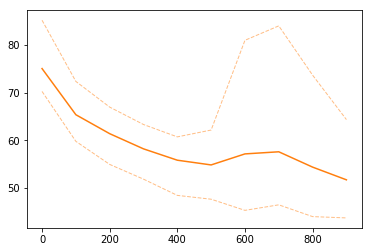

In [128]:
plot_loss([x[3] for x in full_log], 'completely-supervised', 'C1')

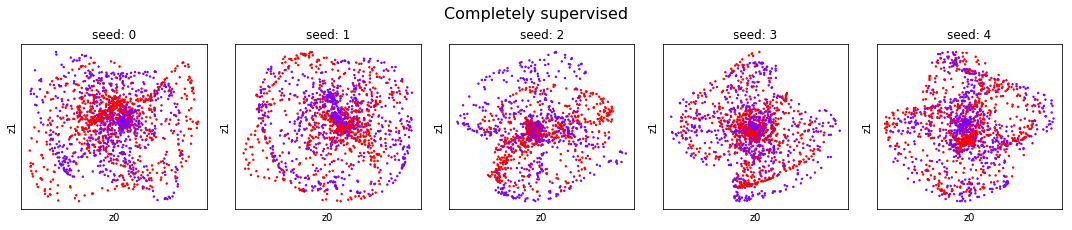

In [115]:
plot2d_latent(full_log, 'full_latent', 'Completely supervised')

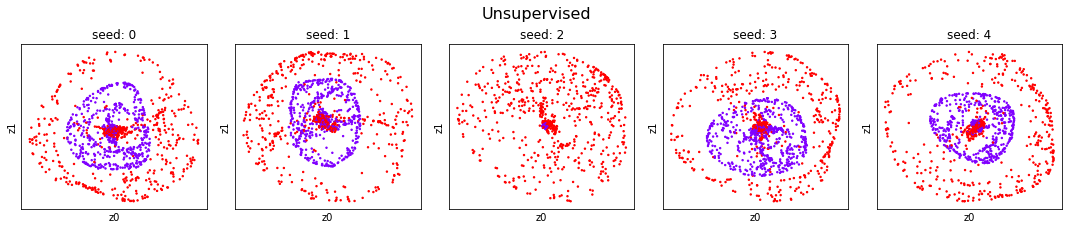

In [116]:
plot2d_latent(unsup_log, 'unusp_latent', 'Unsupervised')

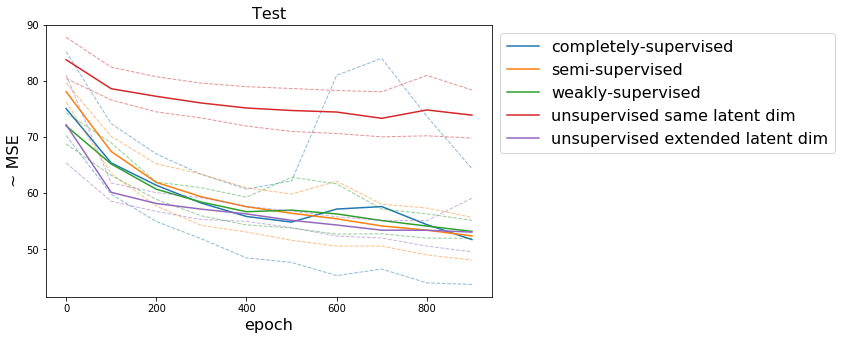

In [124]:
plt.figure(figsize=(8, 5))

plt.title('Test',fontsize=16)
plot_loss([x[3] for x in full_log], 'completely-supervised', 'C0')
plot_loss([x[3] for x in semi_log], 'semi-supervised', 'C1')
plot_loss([x[3] for x in weak_log], 'weakly-supervised', 'C2')
plot_loss([x[3] for x in unsup_log], 'unsupervised same latent dim', 'C3')
plot_loss([x[3] for x in unsupext_log], 'unsupervised extended latent dim', 'C4')
plt.xlabel('epoch',fontsize=16)
plt.ylabel('~ MSE',fontsize=16)
lgd = plt.legend(loc=2, bbox_to_anchor=(1,
                                        1.0), fontsize=16)
plt.savefig('mse_loss_results.png', dpi=300, bbox_to_anchor=(1, 1), bbox_extra_artists=(lgd,), bbox_inches='tight')

In [134]:
m, trl, tel, mse, iwae = train_utils.fit_model_report(None, True,  target_features, num_labels, 
                                                        2, L, device, 200, 
                                                        train_loader, test_loader, 'test', 100)

conv size: 335
fc3 2 10
number of model parameters: 10215
====> Train set loss: 10002.8887, MSE: 100.0248, CE: 0.0000, CE(full): 0.7231, KL: 0.8150
====> Train set loss: 10010.1262, MSE: 100.0997, CE: 0.0000, CE(full): 0.7262, KL: 0.3055
====> Train set loss: 9997.8533, MSE: 99.9648, CE: 0.0000, CE(full): 0.7285, KL: 2.7376
====> Train set loss: 9941.8525, MSE: 98.9936, CE: 0.0000, CE(full): 0.7233, KL: 84.9936
====> Train set loss: 9217.0078, MSE: 87.8810, CE: 0.0000, CE(full): 0.7202, KL: 857.8098
====> Train set loss: 9061.2283, MSE: 85.4248, CE: 0.0000, CE(full): 0.7329, KL: 1037.4965
====> Train set loss: 8845.7468, MSE: 83.0283, CE: 0.0000, CE(full): 0.7216, KL: 1085.8271
====> Train set loss: 8619.1705, MSE: 80.1066, CE: 0.0000, CE(full): 0.7271, KL: 1217.0183
====> Train set loss: 8242.2557, MSE: 75.1567, CE: 0.0000, CE(full): 0.7257, KL: 1453.1770
====> Train set loss: 8122.7581, MSE: 73.5899, CE: 0.0000, CE(full): 0.7279, KL: 1527.5352
epoch: 100
====> Test set loss: 8306.549